In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

import equinox
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [2]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [4]:
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

In [5]:
key = jax.random.PRNGKey(123)

In [6]:
@equinox.filter_jit
def schur_complement(A, B, C, x, y, method=1):
    """Returns a numerically stable(ish) attempt at
    x + B C^(-1) y,
    A - B C^(-1) B^T.
    """
    if method == 1:
        # C = U U^T
        U = jax.scipy.linalg.cholesky(C)
        # B_tilde = B U^-T
        B_tilde = jax.scipy.linalg.solve_triangular(U, B.T, trans=1, lower=False).T
        return (
            x + B_tilde @ jax.scipy.linalg.solve_triangular(U, y, lower=False),
            A - B_tilde.dot(B_tilde.T),
        )

In [7]:
def ccf(*eigenvalues):
    """
    Generate the controllable canonical form (companion matrix) A
    for a system with the given eigenvalues.

    Parameters:
        *eigenvalues: Variable length argument list of eigenvalues (lambda1, lambda2, ..., lambdan)

    Returns:
        A: The controllable canonical form matrix (n x n)
    """
    # Ensure input is treated as a flat list
    eigenvalues = np.array(eigenvalues)

    # Compute the coefficients of the characteristic polynomial
    # The polynomial has the form: s^n + a_{n-1}s^{n-1} + ... + a_1 s + a_0
    poly_coeffs = np.poly(eigenvalues)  # Gives [1, a_{n-1}, ..., a_0]

    # Remove the leading 1 (coefficient of s^n)
    a_coeffs = -poly_coeffs[1:]  # Negative signs for canonical form

    n = len(a_coeffs)
    A = np.zeros((n, n))

    # Fill the last row with the negative coefficients
    A[-1, :] = a_coeffs[::-1]

    # Fill the subdiagonal with 1s
    for i in range(n - 1):
        A[i, i + 1] = 1

    return jnp.array(A)

In [28]:
F[0].A,

(Array([[ 0.      ,  1.      ,  0.      ,  0.      ,  0.      ],
        [ 0.      ,  0.      ,  1.      ,  0.      ,  0.      ],
        [ 0.      ,  0.      ,  0.      ,  1.      ,  0.      ],
        [ 0.147015, -0.10098 , -1.2261  ,  2.18    ,  1.      ]],      dtype=float64),)

In [8]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(21), 5)

n_x = 4
n_u = 1
n_y = 2

n_hidden_output = 100

F = ProbitLinearNetwork(
    ProbitLinear(
        in_size=n_x + n_u,
        out_size=n_x,
        key=key2,
        A=jnp.hstack((ccf(0.99, 0.99, 0.5, -0.3), jnp.zeros((n_x, 1)).at[-1].set(1))),
        b=ZeroMatrix(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
H = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x + n_u,
        out_size=n_hidden_output,
        key=key3,
        A=RandomOrthogonalProjection(1e1),
        b=RandomOrthogonalProjection(1e1),
    ),
    ProbitLinear.create_probit(
        in_size=n_hidden_output,
        out_size=n_y,
        key=key4,
        A=RandomOrthogonalProjection(1e1),
        b=ZeroMatrix(),
    ),
)
H_aug = H.augment_with_identity()

In [9]:
x = F(np.zeros(n_x + n_u))

In [10]:
sim_horizon = 200
Q = jnp.eye(n_x) * 1e-2
R = jnp.eye(n_y) * 1e-4

In [11]:
η_key, ϵ_key = jax.random.split(key, 2)

In [12]:
η = jax.random.multivariate_normal(
    mean=jnp.zeros(n_x), cov=Q, key=η_key, shape=sim_horizon
)

In [13]:
ϵ = jax.random.multivariate_normal(
    mean=jnp.zeros(n_y), cov=R, key=ϵ_key, shape=sim_horizon
)

In [14]:
u = np.zeros((sim_horizon, n_u))
u[100:] = 10

In [15]:
x = np.zeros((sim_horizon, n_x))
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in range(1, sim_horizon):
    x[i, :] = F(x[i - 1, :], u[i - 1, :]) + η[i - 1]
    y_noiseless[i, :] = H(x[i, :], u[i - 1,])
    y[i, :] = y_noiseless[i, :] + ϵ[i]

Preview input, state, and output trajectories

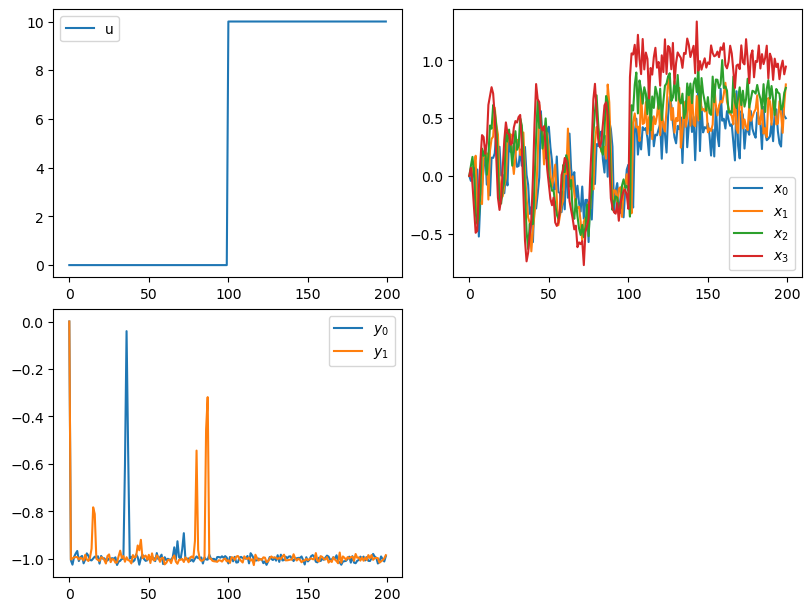

In [16]:
fig = Figure(figsize=(8, 6), dpi=100, constrained_layout=1)
ax = fig.add_subplot(221)
ax.plot(u[:, 0], label="u")
ax.legend()
ax = fig.add_subplot(222)
for i in range(n_x):
    ax.plot(x[:, i], label=rf"$x_{i}$")
ax.legend()
ax = fig.add_subplot(223)
for i in range(n_y):
    ax.plot(y[:, i], label=rf"$y_{i}$")
ax.legend()
fig

In [55]:
method = "analytic"
# method = "linear"
# method = "unscented"

In [56]:
STATES = slice(None, n_x)
INPUTS = slice(n_x, n_x + n_u)
OUTPUTS = slice(n_x + n_u, None)
JOINT = slice(None, n_x + n_u + n_y)

joint_prediction = np.zeros((sim_horizon, n_x + n_u + n_y))
P_pred = np.zeros((sim_horizon, n_x + n_u + n_y, n_x + n_u + n_y))
P_post = np.zeros((sim_horizon, n_x, n_x))

joint_prediction[0, STATES] = -2
P_pred[0, STATES, STATES] = Q * 1
P_post[0, STATES, STATES] = Q * 1

In [57]:
for i in trange(1, sim_horizon):
    # predict x
    joint_prediction[i, STATES], P_pred[i, STATES, STATES] = F.propagate_mean_cov_block(
        (joint_prediction[i - 1, STATES], u[i - 1, :]),
        (P_post[i - 1, STATES, STATES], 0.0),
        method=method,
    )
    P_pred[i, STATES, STATES] += Q
    # predict y
    joint_prediction[i, JOINT], P_pred[i, JOINT, JOINT] = (
        H_aug.propagate_mean_cov_block(
            (joint_prediction[i, STATES], u[i, :]),
            (P_pred[i, STATES, STATES], 0.0),
            method=method,
        )
    )
    P_pred[i, OUTPUTS, OUTPUTS] += R
    # correct x
    joint_prediction[i, STATES], P_post[i, STATES, STATES] = schur_complement(
        P_pred[i, STATES, STATES],
        P_pred[i, STATES, OUTPUTS],
        P_pred[i, OUTPUTS, OUTPUTS],
        joint_prediction[i, STATES],
        y[i, :] - joint_prediction[i, OUTPUTS],
    )
    if np.any(np.isnan(joint_prediction[i])):
        print(i)
        raise KeyboardInterrupt

  0%|          | 0/199 [00:00<?, ?it/s]

In [58]:
x_pred = joint_prediction[:, STATES]
x_pred_std = jax.vmap(jnp.diag)(P_pred[:, STATES, STATES]) ** 0.5
y_pred = joint_prediction[:, OUTPUTS]
y_pred_std = jax.vmap(jnp.diag)(P_pred[:, OUTPUTS, OUTPUTS]) ** 0.5

In [59]:
print('normalized rmse', ((x - x_pred) ** 2).mean() ** 0.5 /  np.std(x))

normalized rmse 0.6211609972430155


In [60]:
time_slice = slice(1, None)

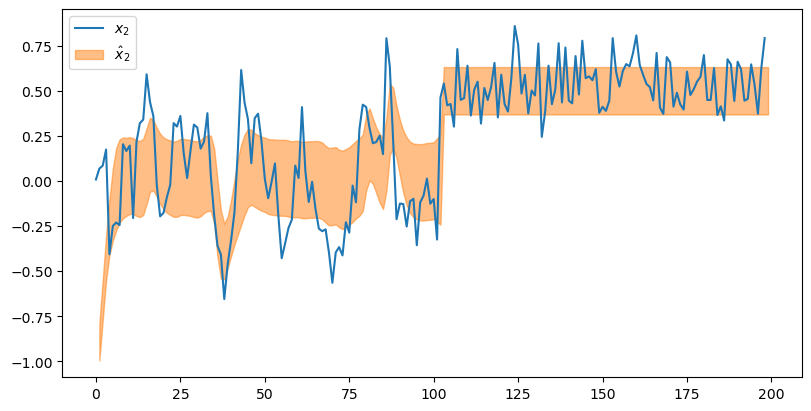

In [64]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x[time_slice, 1], label='$x_2$')
ax.fill_between(
    np.arange(sim_horizon)[time_slice],
    (x_pred[time_slice, 1] - x_pred_std[time_slice, 1]),
    (x_pred[time_slice, 1] + x_pred_std[time_slice, 1]),
    color="C1",
    alpha=0.5,
    label=r'$\hat x_2$'
)
ax.legend()
fig

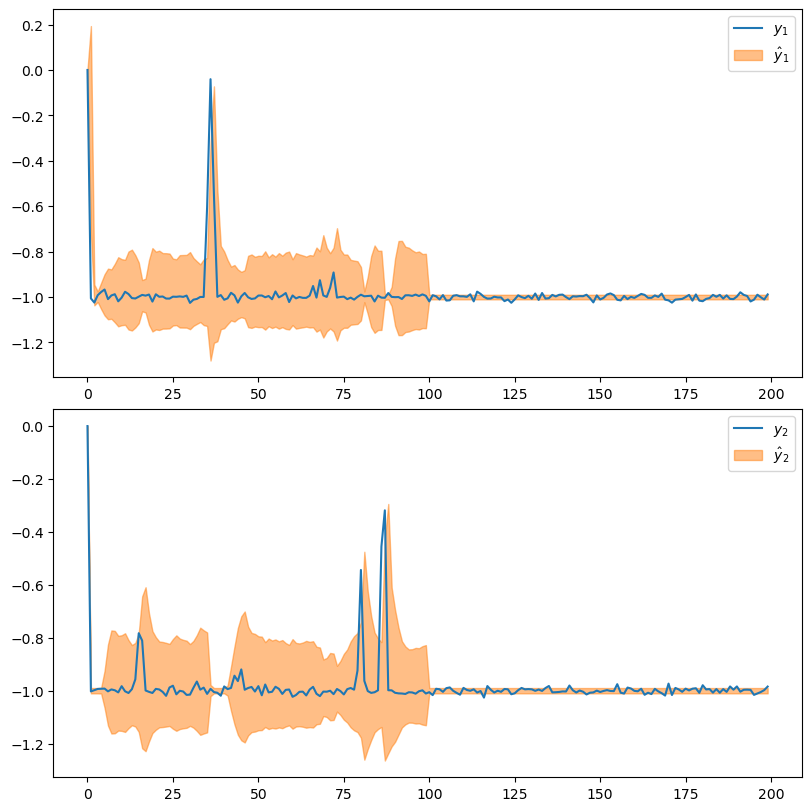

In [65]:
fig = Figure(figsize=(8, 8), dpi=100, constrained_layout=1)
for i in range(n_y):
    ax = fig.add_subplot(n_y, 1, i+1)
    ax.plot(y[:, i], label=rf'$y_{i+1}$')
    ax.fill_between(
        np.arange(sim_horizon),
        y_pred[:, i] - y_pred_std[:, i],
        y_pred[:, i] + y_pred_std[:, i],
        color="C1",
        alpha=0.5,
        label=rf'$\hat y_{i+1}$'
    )
    ax.legend()
fig